# TP 2.3. Etats de Marché

**Hugo Yeremian, Martín Pasche**

In [39]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sknetwork.clustering import Leiden
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
from dateutil.relativedelta import relativedelta
import datetime
from tqdm import tqdm

pd.set_option('display.max_columns', 100)

In [2]:
import xgboost as xgb


# 1. Détermination d'états de marché

In [6]:
df = pd.read_parquet('data/sp500_20161229.parquet')
df.set_index('index', inplace=True)
df.shape

(3145, 328)

In [7]:
df

,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,AEP,AES,AET,AIV,ALL,ALTR,AMAT,AMD,AMGN,AMP,AMZN,AN,ANTM,AON,APA,APD,ASH,ATI,AVP,AVY,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BC,BDX,BEN,BIG,BIIB,BK,BLL,BMS,BMY,BSX,BTU,BXP,CA,...,SYK,SYMC,SYY,T,TAP,TER,TEX,TGNA,TGT,THC,TIF,TJX,TMK,TMO,TROW,TSG,TSN,TXN,TXT,UIS,UNH,UNP,UPS,USB,UTX,VFC,VIAB,VLO,VMC,VNO,VRSN,VZ,WAT,WB,WFT,WHR,WIN,WM,WMB,WMT,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,0.007280,0.023373,-0.002651,0.022445,0.012206,0.030761,0.021739,0.058824,0.019021,0.026829,0.009120,0.012425,-0.005389,0.036161,0.034734,0.007096,0.034888,-0.000831,-0.009107,0.019179,0.011008,0.001424,0.020152,0.018858,0.006916,0.009544,0.028749,0.003935,0.006158,0.020104,0.014155,0.031105,0.020722,0.012336,0.026552,0.011314,-0.001225,0.045863,0.016592,-0.010997,...,0.003826,-0.001714,0.001288,0.008983,0.002388,0.014413,0.024242,0.024104,-0.004548,-0.005222,0.012797,-0.003444,0.005583,0.004978,0.013328,NaN,-0.022807,0.036483,0.006755,-0.003431,-0.006598,-0.004471,0.005323,0.013048,0.011089,-0.005782,NaN,0.053488,0.013579,0.030790,-0.016423,0.008632,0.007937,NaN,0.061050,-0.013013,0.042105,0.010544,0.031506,-0.012179,NaN,0.004522,0.005959,0.012615,0.022213,0.040947,0.017747,-0.002773,0.015421,0.012176
2006-01-04,0.002687,0.005686,0.001467,-0.006626,0.001517,-0.009794,0.009264,0.003238,-0.005951,-0.005013,-0.001606,0.042593,0.003827,0.009039,-0.001096,0.003880,0.008729,0.004938,-0.004729,0.031354,-0.006936,0.016364,0.002016,0.003490,-0.002821,-0.011407,-0.004506,0.066574,0.012725,0.014912,-0.009271,0.011800,-0.010620,0.013816,0.000552,0.007800,-0.015202,-0.001225,0.014888,0.001251,0.000821,0.011418,0.004922,0.044019,0.010486,-0.014316,0.034751,0.023550,0.003715,0.015782,...,0.017265,0.031065,0.006122,0.007285,-0.004468,-0.005413,0.010848,0.014025,-0.001279,0.018373,-0.014698,0.050540,0.001254,0.007596,0.004521,NaN,0.005984,0.009025,-0.000129,0.044750,0.002430,-0.000873,0.001324,0.003633,-0.006015,-0.003453,NaN,0.010118,-0.011359,0.001627,-0.021800,0.029296,-0.007087,NaN,0.014580,0.004597,0.010101,-0.013042,0.006276,0.001947,NaN,0.024160,0.004847,0.020519,0.044610,0.001710,-0.001341,0.008556,0.009492,0.007061
2006-01-05,0.026198,0.007981,0.013669,-0.012387,0.010856,-0.009110,0.031857,-0.008391,-0.014722,-0.008527,-0.005630,-0.009473,-0.010485,0.016637,0.002744,0.028992,0.012439,0.034398,-0.014504,0.011746,0.008466,-0.002683,-0.006665,-0.007491,-0.021499,-0.008654,-0.009891,0.029909,0.001047,-0.007521,0.000871,-0.011803,0.001288,-0.008743,-0.023616,0.000000,-0.012486,-0.005396,-0.007009,-0.011664,0.022149,-0.003251,0.004897,-0.003811,-0.005534,0.000000,0.022126,-0.025275,0.015336,0.001766,...,-0.011461,0.015395,-0.003857,0.002411,0.001645,0.033333,-0.002927,-0.006041,-0.002928,-0.010309,0.009422,-0.004934,-0.006980,-0.002622,-0.000818,NaN,-0.002974,0.017889,-0.002194,0.008237,-0.003070,-0.011489,0.000397,0.004936,-0.003737,0.006748,NaN,-0.002550,0.010605,0.006498,0.009483,0.011513,-0.015067,NaN,-0.018476,0.001565,0.007500,0.003964,-0.010395,-0.013601,NaN,-0.008791,-0.000536,-0.001867,0.060566,-0.004951,-0.010745,0.042630,-0.010560,0.009089
2006-01-06,0.005222,-0.003299,0.040453,-0.011095,0.021229,0.024429,0.003925,0.008679,0.057798,0.014660,0.015638,0.016139,0.003853,0.012588,0.000365,0.006082,0.034722,0.002969,-0.009135,-0.007512,0.004617,0.004484,-0.000760,-0.004043,0.013732,0.023280,0.085506,0.022222,-0.012901,0.011280,-0.010546,-0.013934,-0.001501,0.005966,0.004781,-0.002580,0.081609,0.010358,0.018549,0.009905,-0.008026,0.001273,0.013098,0.006934,0.008696,0.006628,0.014302,0.023721,0.020182,0.009517,...,0.006466,0.039366,0.008390,0.012595,0.015532,0.033575,0.034083,0.020793,-0.002936,0.007812,0.009852,0.013223,0.006849,0.000329,0.008190,NaN,0.002983,0.009080,0.003363,0.000000,0.019614,-0.007327,-0.005946,0.007859,0.003215,

In [8]:
fenetre_T = 20
fenetre_T

20

In [9]:
nan_columns = df.columns[df.isna().any()].tolist()
print(nan_columns)

['AA', 'ALTR', 'BIIB', 'BTU', 'CBH', 'CPWR', 'DTV', 'FDC', 'FITB', 'FMCC', 'FNMA', 'GEC', 'GNW', 'HIG', 'HLT', 'LNC', 'MS', 'MTG', 'NCRA', 'SNV', 'SUN', 'TSG', 'UIS', 'VIAB', 'WB', 'WU', 'XL']


On supprime d’abord toutes les colonnes comportant au moins un NA sur l’ensemble de la période, puis on choisit un sous‑univers de $N=300$ titres, avec $N>T=20$.

In [10]:
df_2 = df[[col for col in df.columns if col not in nan_columns]].copy()
df_2.shape

(3145, 301)

$N>T$ : Matrice de corrélation empirique singularisée, identifiée par la frontière de Marchenko-Pastur

In [11]:
N = 300
df_3 = df_2.iloc[:, :N].copy()

tranche = [df_3.iloc[i:i+fenetre_T] for i in range(0, df_3.shape[0]-fenetre_T)]

In [12]:
def compute_filtered_C(R):
    
    # R is N x T
    try:
        N, T = R.shape
        C = np.corrcoef(R)
        U, s, VT = np.linalg.svd(C)
        
        q = T / N
        lmbda_plus = (1 + np.sqrt(q))**2
        lmbda_M = np.max(s)
        
        C_filter = np.zeros_like(C)
        for i in range(len(s)):
            if lmbda_plus < s[i] < lmbda_M:
                v = U[:, i].reshape(-1, 1)
                C_filter += (v @ v.T ) * s[i] 
        return C_filter
    
    except Exception as e:
        print(e)
        return None


def LeidenCorrelationClustering(C_s):   # C_s is the filtered correlation matrix

    C_s = np.abs(C_s)

    adjacency = sparse.csr_matrix(C_s)   # C_s is not sparse but it is the only current format that works for now.


    leiden = Leiden()
    labels = leiden.fit_predict(adjacency)

    return labels

- On calcule la matrice de corrélation $C$ sur la fenêtre $T$.
- On réalise une SVD / décomposition spectrale $C=U \Sigma U^T$.
- On calcule la borne supérieure $\lambda_{+}=(1+\sqrt{T / N})^2$ de la distribution de Marchenko-Pastur.
- On ne reconstruit que la partie "significative" :

$$
C_{\mathrm{filt}}=\sum_{\lambda_i>\lambda_{+}} \lambda_i u_i u_i^T
$$

- But : éliminer le bruit lié aux petites valeurs propres et ne garder que les facteurs de corrélation réellement stables.

Etats : Fenetre x Titre 

In [13]:
if not os.path.exists('etats.npy'):
    
    etats = np.zeros((len(tranche), N))
    for i in range(len(tranche)):
        R = tranche[i]
        R = R.dropna()
        C_filter = compute_filtered_C( R.values.T )
        labels = LeidenCorrelationClustering(C_filter)
        etats[i, :] = labels
    np.save('etats.npy', etats)
else:
    etats = np.load('etats.npy')

- On prend la matrice $C_{filt}$ comme matrice d’adjacence pondérée (valeurs absolues).
- On la convertit en scipy.sparse.csr_matrix pour la passer à sknetwork.clustering.Leiden.
- L’algorithme de Leiden détecte automatiquement un nombre de clusters (états) « optimal » à chaque fenêtre.
- Les labels allant de 0 à K−1 sont stockés dans la matrice etats[i, :].

## 1.5. Tracez le nombre d’états de marché en fonction du temps

In [14]:
etats.shape, df_3.iloc[fenetre_T:].shape

((3125, 300), (3125, 300))

In [15]:
df_etats = pd.DataFrame(etats, index=df_3.index[fenetre_T:], columns=df_3.columns)
df_etats.head(1)

,A,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,AEP,AES,AET,AIV,ALL,AMAT,AMD,AMGN,AMP,AMZN,AN,ANTM,AON,APA,APD,ASH,ATI,AVP,AVY,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BC,BDX,BEN,BIG,BK,BLL,BMS,BMY,BSX,BXP,CA,CAG,CAH,CAT,CB,...,SRE,SSP,STI,STT,STZ,SVU,SWK,SYK,SYMC,SYY,T,TAP,TER,TEX,TGNA,TGT,THC,TIF,TJX,TMK,TMO,TROW,TSN,TXN,TXT,UNH,UNP,UPS,USB,UTX,VFC,VLO,VMC,VNO,VRSN,VZ,WAT,WFT,WHR,WIN,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRX,YUM,ZBH
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-02-01,5.0,5.0,0.0,4.0,0.0,4.0,6.0,0.0,4.0,4.0,4.0,0.0,5.0,1.0,4.0,2.0,1.0,0.0,1.0,0.0,0.0,6.0,3.0,0.0,0.0,4.0,3.0,2.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,0.0,1.0,4.0,...,5.0,2.0,0.0,2.0,5.0,0.0,1.0,2.0,2.0,6.0,4.0,0.0,3.0,0.0,2.0,1.0,1.0,0.0,6.0,2.0,2.0,3.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0,3.0,1.0,5.0,1.0,4.0,2.0,3.0,2.0,3.0,2.0,3.0,4.0,6.0,4.0,3.0,3.0,6.0,3.0,2.0


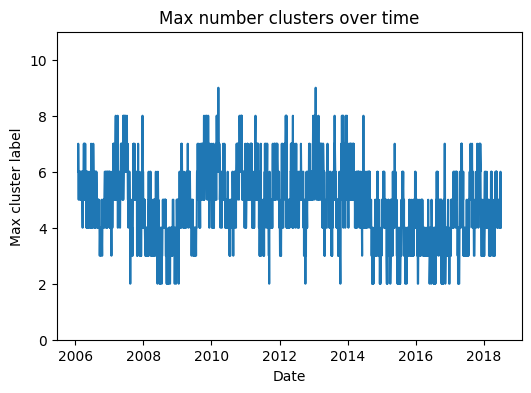

In [16]:
df_temp = pd.DataFrame({
    'max_etats' : np.max(etats,axis = 1),
}, index = df_3.iloc[fenetre_T:].index)

plt.figure(figsize=(6, 4))
plt.plot(df_temp, label='max')
plt.xlabel('Date')
plt.ylabel('Max cluster label')
plt.title('Max number clusters over time')
plt.ylim(0, 11)
plt.show()

In [17]:
etats.shape

(3125, 300)

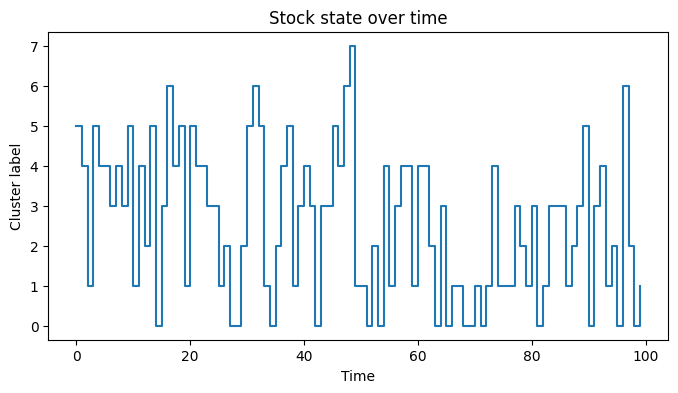

In [18]:
time_range = 100
stock = 0

stock_state = etats[:, stock]

plt.figure(figsize=(8, 4))
plt.step(range(time_range), stock_state[:time_range], where='post', label='stock {}'.format(stock))
plt.title("Stock state over time")
plt.xlabel('Time')
plt.ylabel('Cluster label')
plt.show()

Plus on identifie d’états en même temps, plus la “structure” des corrélations est riche / fragmentée (marché chaotique). On remarque que post-2008 et jusqu'en 2014, le moyenne des états était plutôt à des périodes de 6 états de marché tandis qu'à partir de 2014, plutôt une moyenne de 3 à 4 états de marché.

# 2. Stratégies basées sur les états de marchés

In [46]:
def LeidenCorrelationClustering(C):
    W = np.abs(C)
    A = sparse.csr_matrix(W)
    labels = Leiden().fit_predict(A)
    return labels

def compute_filtered_C(R):
    N, T = R.shape
    C = np.corrcoef(R)
    U, s, _ = np.linalg.svd(C)
    q = T / N
    lambda_plus = (1 + np.sqrt(q))**2
    C_filt = np.zeros_like(C)
    for i, lam in enumerate(s):
        if lam > lambda_plus:
            u = U[:, i].reshape(-1, 1)
            C_filt += lam * (u @ u.T)
    return C_filt

In [41]:
def get_states(df, T, step=1):
    """
    For each window [i : i+T], compute C_filtered, run Leiden,
    and record the *max* cluster‐label in that window.
    """
    states = {}
    for i in tqdm(range(0, len(df) - T, step), desc="Computing states"):
        window = df.iloc[i:i+T].dropna(axis=1)
        R = window.values.T
        C_filt = compute_filtered_C(R)
        labels = LeidenCorrelationClustering(C_filt)
        states[i] = labels.max()
    return states

def filldf_states(df, T):
    raw = get_states(df, T)
    # align by date: pad first T days with NaN, then the scalar states
    sorted_states = [ raw[i] for i in sorted(raw) ]
    df2 = df.copy()
    df2['states'] = [np.nan]*T + sorted_states
    return df2

In [42]:
def strat(returns, market_state):
    """
    Pick all tickers whose (mean / var) on past days with this
    market_state beats the average of the market.
    """
    subset = returns[returns['states'] == market_state].iloc[:, :-1]
    mu = subset.mean()
    sigma = subset.std()
    sharpe = mu / (sigma**2)
    avg_sh = mu.mean() / (sigma.mean()**2)
    picks = sharpe[sharpe > avg_sh].index.tolist()
    return picks

def create_stocks_list(df, T):
    stocks_at_t = []
    for t in tqdm(range(T, len(df)), desc="Stock selection"):
        state_t = df.at[df.index[t], 'states']
        picks = strat(df.iloc[:t+1], state_t)
        stocks_at_t.append(picks)
    return stocks_at_t

In [ ]:
def cum_perf(df, T):
    df2 = filldf_states(df, T)
    assets = [c for c in df2.columns if c != 'states']
    good = df2[assets].dropna(axis=1).columns
    df2 = df2[good.tolist() + ['states']]
    picks = create_stocks_list(df2, T)
    perf = np.zeros(len(picks))
    portfolio = set()

    for t in tqdm(range(len(picks)), desc="Backtest"):
        date_idx = t + T
        if portfolio:
            for stk in portfolio:
                perf[t] += df2.at[df2.index[date_idx], stk] / len(portfolio)
        # remove dropped tickers
        portfolio -= set(s for s in portfolio if s not in picks[t])
        # add new picks
        portfolio |= set(s for s in picks[t] if s not in portfolio)

    return perf

In [44]:
df = pd.read_parquet('data/sp500_20161229.parquet')
df.set_index('index', inplace=True)
df = df.dropna(axis=1).iloc[:, :300]

T = 20
perf = cum_perf(df, T)

Backtest: 100%|██████████| 3125/3125 [00:03<00:00, 781.99it/s]


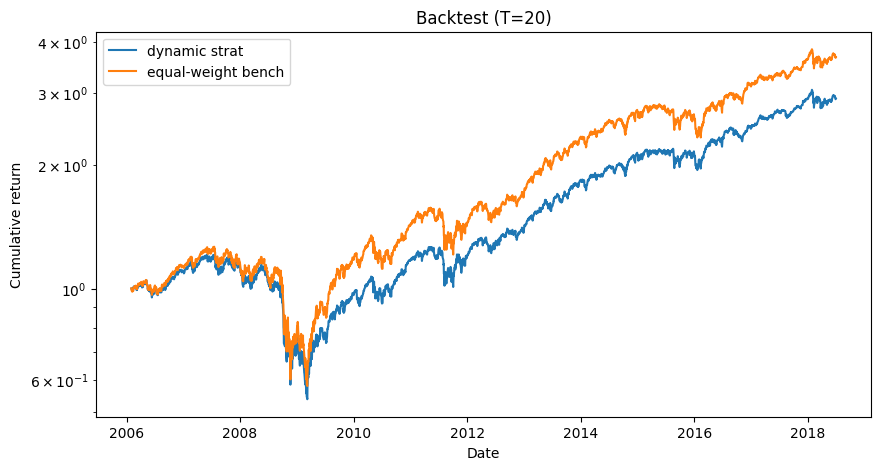

In [47]:
bench = np.zeros(len(perf))
df_assets = df.dropna(axis=1)
for t in range(len(perf)):
    bench[t] = df_assets.iloc[t+T].mean()

dates = df.index[T:]
plt.figure(figsize=(10,5))
plt.plot(dates, np.cumprod(1+perf), label="dynamic strat")
plt.plot(dates, np.cumprod(1+bench), label="equal‑weight bench")
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.title(f"Backtest (T={T})")
plt.legend()
plt.show()

In [50]:
T = 60
perf = cum_perf(df, T)

Backtest: 100%|██████████| 3085/3085 [00:03<00:00, 786.73it/s]


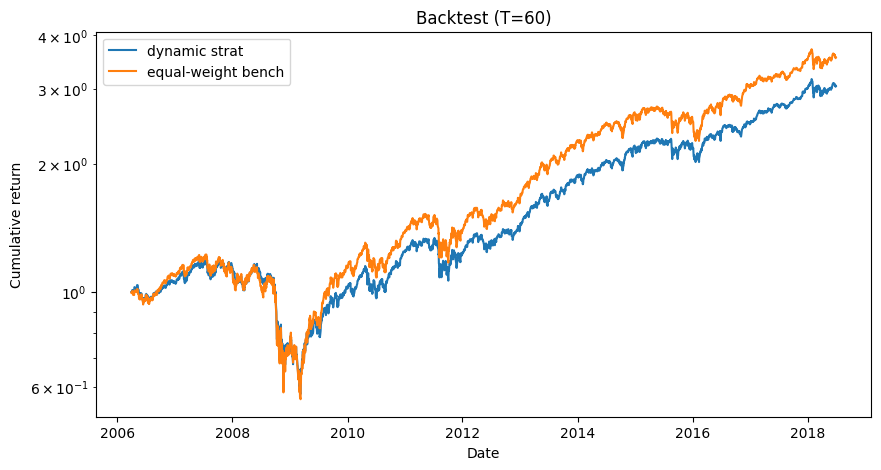

In [51]:
bench = np.zeros(len(perf))
df_assets = df.dropna(axis=1)
for t in range(len(perf)):
    bench[t] = df_assets.iloc[t+T].mean()

dates = df.index[T:]
plt.figure(figsize=(10,5))
plt.plot(dates, np.cumprod(1+perf), label="dynamic strat")
plt.plot(dates, np.cumprod(1+bench), label="equal‑weight bench")
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.title(f"Backtest (T={T})")
plt.legend()
plt.show()

Bien que nous supposons les frais de transactions nuls, avec notre stratégie (avec une fenêtre de calibration de 100) basée sur les états de marché, nous arrivons à faire la même performance qu'un indice equipondéré.

### Another strategy investing in the cluster with highest returns

## 2.1. Stratégie “cluster le plus performant”  

**Principe :**  
1. On fixe une fenêtre de calibration de taille `fenetre_T` (ici 60 jours).  
2. À chaque pas `i`, on regarde les rendements passés `past_df = df_3[i : i+fenetre_T]`.  
3. On calcule pour chaque titre sa moyenne de rendement sur la fenêtre :  
   ```python
   stock_mean = past_df.mean(axis=0)

In [54]:
fenetre_T = 60
time_horizon = 3_000

strategy = np.zeros(time_horizon)
dates = df_3.index[fenetre_T : fenetre_T + time_horizon].tolist()

for i in range( time_horizon):

    past_df = df_3.iloc[i : fenetre_T + i].copy()
    returns_t_plus_1 = df_3.iloc[fenetre_T + i].copy()

    stock_mean = past_df.mean(axis=0)
    market_state = etats[i].astype(int)

    df_mean = pd.DataFrame({
        'mean' : stock_mean,
        'market_state' : market_state,
    })

    grouped_means = df_mean.groupby('market_state').mean()
    grouped_means.sort_values(by='mean', ascending=False, inplace=True)
    best_cluster = grouped_means.index[0]

    num_best_assets = np.count_nonzero(market_state == best_cluster) 
    
    weight = 1 / num_best_assets

    df_returns_t_plus_1 = pd.DataFrame({
        'returns' : returns_t_plus_1,
        'market_state' : market_state,
    })

    strategy[i] = np.sum(df_returns_t_plus_1[df_returns_t_plus_1['market_state'] == best_cluster]['returns'] * weight)   
    

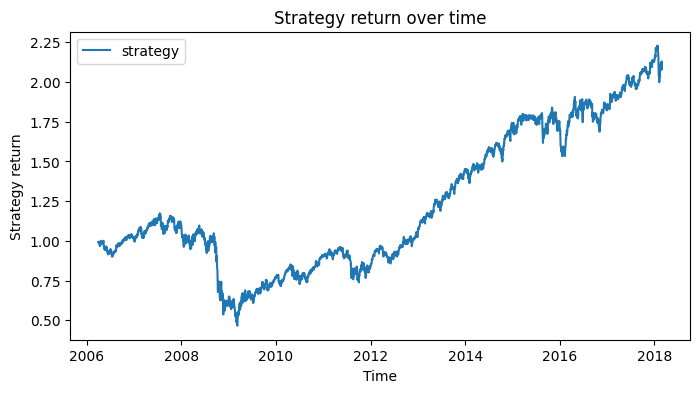

In [55]:
df_strat = pd.DataFrame({
    'strategy' : strategy,
}, index = dates)

plt.figure(figsize=(8, 4))
plt.plot( df_strat.index, np.cumprod(strategy + 1), label='strategy')
plt.xlabel('Time')
plt.ylabel('Strategy return')
plt.title('Strategy return over time')
plt.legend()
plt.show()

In [56]:
data = df_3.iloc[fenetre_T: fenetre_T + time_horizon].copy()
data = np.cumprod( (1 + data), axis = 0)

final_returns = data.iloc[-1]
top = final_returns.sort_values(ascending=False)[5:10]
mean_stock = final_returns.sort_values(ascending=False).iloc[ len(final_returns) // 2]


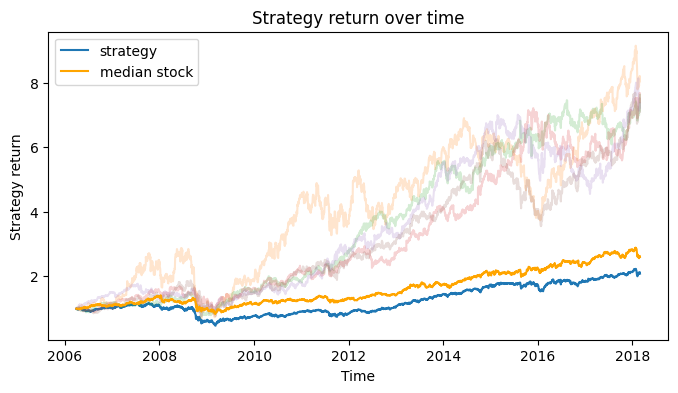

In [57]:
data = df_3.iloc[fenetre_T: fenetre_T + time_horizon].copy()
data = np.cumprod( (1 + data), axis = 0)

final_returns = data.iloc[-1]
top = final_returns.sort_values(ascending=False).index[5 : 10]
median_stock = final_returns.sort_values(ascending=False).index[len(final_returns) //2]

plt.figure(figsize=(8, 4))
plt.plot( df_strat.index, np.cumprod(strategy + 1), label='strategy')
plt.plot( data[top], alpha=0.2)
plt.plot( data[median_stock], label='median stock', color='orange')
plt.xlabel('Time')
plt.ylabel('Strategy return')
plt.title('Strategy return over time')
plt.legend()
plt.show()

Strategy with top k most performing stocks in the cluster

Cette fois‑ci, on choisit uniquement les k titres les plus performants à l’intérieur de ce cluster

On alloue un poids égalisé à ces k titres pour la journée suivante

In [70]:
fenetre_T = 60
time_horizon = 3_000

strategy = np.zeros(time_horizon)
dates = df_3.index[fenetre_T : fenetre_T + time_horizon].tolist()

for i in range( time_horizon):

    past_df = df_3.iloc[i : fenetre_T + i].copy()
    returns_t_plus_1 = df_3.iloc[fenetre_T + i].copy()

    stock_mean = past_df.mean(axis=0)
    market_state = etats[i].astype(int)

    df_mean = pd.DataFrame({
        'mean' : stock_mean,
        'market_state' : market_state,
    })
    
    df_returns_t_plus_1 = pd.DataFrame({
        'returns' : returns_t_plus_1,
        'market_state' : market_state,
    })

    grouped_means = df_mean.groupby('market_state').mean()
    grouped_means.sort_values(by='mean', ascending=False, inplace=True)
    best_cluster = grouped_means.index[0]
    
    k = 10
    best_assets = df_mean[df_mean['market_state'] == best_cluster].nlargest(k, 'mean').index
    returns = returns_t_plus_1[best_assets]
    strategy[i] = returns.mean()

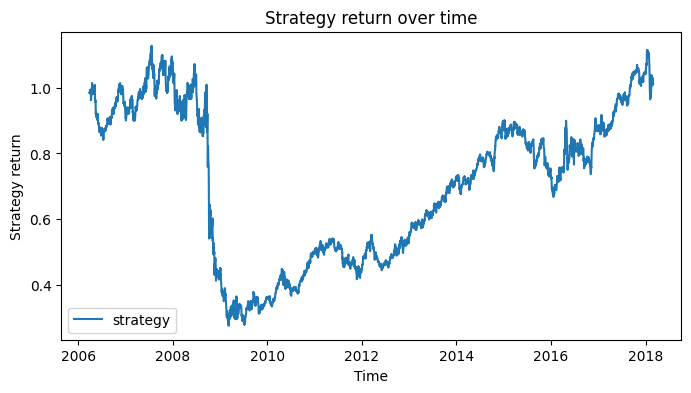

In [71]:
df_strat = pd.DataFrame({
    'strategy' : strategy,
}, index = dates)

plt.figure(figsize=(8, 4))
plt.plot( df_strat.index, np.cumprod(strategy + 1), label='strategy')
plt.xlabel('Time')
plt.ylabel('Strategy return')
plt.title('Strategy return over time')
plt.legend()
plt.show()

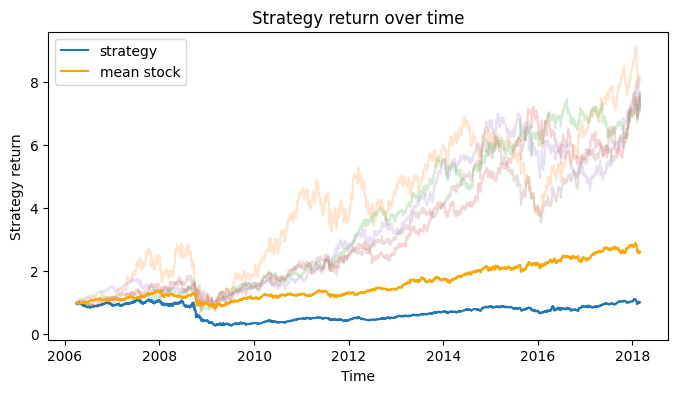

In [72]:
data = df_3.iloc[fenetre_T: fenetre_T + time_horizon].copy()
data = np.cumprod( (1 + data), axis = 0)

final_returns = data.iloc[-1]
top = final_returns.sort_values(ascending=False).index[5 : 10]
mean_stock = final_returns.sort_values(ascending=False).index[len(final_returns) //2]

plt.figure(figsize=(8, 4))
plt.plot( df_strat.index, np.cumprod(strategy + 1), label='strategy')
plt.plot( data[top], alpha=0.2)
plt.plot( data[mean_stock], label='mean stock', color='orange')
plt.xlabel('Time')
plt.ylabel('Strategy return')
plt.title('Strategy return over time')
plt.legend()
plt.show()

# 3. Prédiction de la direction d’un titre financier avec de l’apprentissage machine

In [73]:
date_0 = df_3.index[0]

date_1 = df_3.index[10]
date_2 = df_3.index[-1]

diff_1 = date_1 - date_0
diff_2 = date_2 - date_0

t0 = diff_1.days
t1 = diff_2.days

In [62]:
a = [1,2,3]
b = [4,5,6]

np.array([a, b])

array([[1, 2, 3],
       [4, 5, 6]])

In [63]:
data = df_3.loc[df_etats.index].iloc[:, 0]
np.where(data > 0, 1, 0)

array([1, 0, 1, ..., 0, 1, 1], shape=(3125,))

In [64]:
df_etats.iloc[:, 0][0: 10].to_list()

[5.0, 4.0, 1.0, 5.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0]

In [65]:
etats[:, 0][10: 12]

array([1., 4.])

In [66]:
etats[:, 0][:10]

array([5., 4., 1., 5., 4., 4., 3., 4., 3., 5.])

In [67]:
def create_predictor_matrix (states, K, t_0, t_1):
    P_list = []
    for i in range( t_0 , t_1 - K + 2):
        P_list.append(
            list(states[i : i + K])
        )
        
    P = np.array(P_list)   
    return P


def create_sign_vector (data, K, t_0, t_1):
    return np.where(data[t_0 + K : t_1 + 2] > 0, 1, 0)

P = create_predictor_matrix(df_etats.iloc[:, 0].to_list(), 
                        K = 5, 
                        t_0 = 1 , 
                        t_1 = 100)


data = df_3.loc[df_etats.index].copy()

Y = create_sign_vector (data.iloc[:, 0],
                        K = 5,
                        t_0 = 1,
                        t_1 = 100)


len(Y), P.shape

(96, (96, 5))

On utilise un XGBoostClassifier (logistique binaire) avec :
max_depth=1, eta=0.1, n_estimators=100

In [75]:
time_prediction_horizon = 1000
K = 20
t0 = 0
t1 = 300
stock = 15

data = df_3.loc[df_etats.index].copy()

params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.3,
    'seed': 42,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'
}

y_preds = []

for i in range(time_prediction_horizon):
    
    P = create_predictor_matrix(df_etats.iloc[:, stock].to_list(), 
                        K = K, 
                        t_0 = t0 + i , 
                        t_1 = t1 + i)
    
    Y = create_sign_vector (data.iloc[:, stock],
                        K = K,
                        t_0 = t0 + i,
                        t_1 = t1 + i)
    
    train_X = P[:-1, :]
    train_Y = Y[:-1]
    
    model = xgb.XGBClassifier(**params)
    
    try:
        model.fit(train_X, train_Y)
    except ValueError as e:
        print(e)
        print(train_X.shape, len(train_Y))
        print(train_Y)
    
    y_pred = model.predict(P[-1:, :])[0]
    y_preds.append(y_pred)
    
y_real = (data.iloc[t1 + 1 : t1 + time_prediction_horizon + 1, stock] > 0).astype(int)
accuracy_score(y_real, y_preds)  

0.508

on remarque que la strat marche pas : Accuracy du classifier : accuracy = 0.503 (≈ 0.503, proche du hasard)

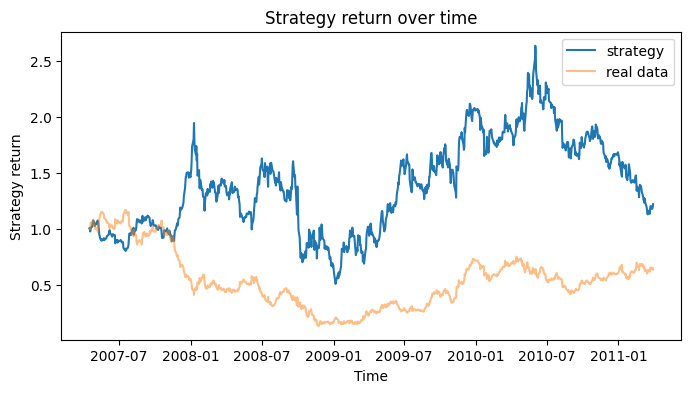

In [ ]:
real_data = data.iloc[t1 + 1 : t1 + time_prediction_horizon + 1, stock]
strategy = np.array(real_data) * np.where( np.array(y_preds) == 1, 1, -1)

df_strat = pd.DataFrame({
    'strategy' : strategy,
}, index = data.index[t1 + 1 : t1 + time_prediction_horizon + 1])

plt.figure(figsize=(8, 4))
plt.plot( df_strat.index, np.cumprod(strategy + 1), label='strategy')
plt.plot( real_data.index, np.cumprod(real_data + 1), label='real data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Strategy return')
plt.title('Strategy return over time')
plt.legend()
plt.show()

The strategy is outpeforming slightly the underlying asset but we can see that the volatility is way higher and the ability to short might be the reason of that stronger performance and volatility as it multiplies the variance of possibilities everytime we rebalance.